# Pharma Sales Forecast

**Problem Statement** : This project focuses on addressing the challenges of time series analysis and forecasting in the pharmaceutical sales domain. Sales data can often be highly uncertain, and performance appears to follow random patterns, especially in smaller scale analyses. The objective is to analyze historical sales data from 2014 to 2019 to identify trends and patterns, and then develop forecasting models to predict future sales with greater accuracy. By leveraging this data, the project aims to improve the precision of monthly sales predictions for pharmaceutical drugs.

---

**References**:
Dataset : https://www.kaggle.com/datasets/milanzdravkovic/pharma-sales-data

To get Understanding of Problem and approach : https://www.kaggle.com/code/milanzdravkovic/pharma-sales-data-analysis-and-forecasting

Prophet : https://youtu.be/j0eioK5edqg?si=f8kQBslA3Zsg7hd2

### Load the data

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [ ]:
sales_df = pd.read_csv('salesdaily.csv')
print("CSV Columns:", sales_df.columns.tolist())

CSV Columns: ['datum', 'M01AB', 'M01AE', 'N02BA', 'N02BE', 'N05B', 'N05C', 'R03', 'R06', 'Year', 'Month', 'Hour', 'Weekday Name']


In [ ]:
sales_df['datum'] = pd.to_datetime(sales_df['datum'], errors='coerce', dayfirst=True)

sales_df.set_index('datum', inplace=True)

print(" Dataset Loaded Successfully!")
print("\n Date Range:", sales_df.index.min(), "to", sales_df.index.max())
print("\n Columns:\n", sales_df.columns.tolist())
print("\n Sample Data:\n", sales_df.head())


 Dataset Loaded Successfully!

 Date Range: 2014-01-02 00:00:00 to 2019-12-09 00:00:00

 Columns:
 ['M01AB', 'M01AE', 'N02BA', 'N02BE', 'N05B', 'N05C', 'R03', 'R06', 'Year', 'Month', 'Hour', 'Weekday Name']

 Sample Data:
             M01AB  M01AE  N02BA  N02BE  N05B  N05C   R03  R06  Year  Month  \
datum                                                                        
2014-02-01    0.0   3.67    3.4  32.40   7.0   0.0   0.0  2.0  2014      1   
2014-03-01    8.0   4.00    4.4  50.60  16.0   0.0  20.0  4.0  2014      1   
2014-04-01    2.0   1.00    6.5  61.85  10.0   0.0   9.0  1.0  2014      1   
2014-05-01    4.0   3.00    7.0  41.10   8.0   0.0   3.0  0.0  2014      1   
2014-06-01    5.0   1.00    4.5  21.70  16.0   2.0   6.0  2.0  2014      1   

            Hour Weekday Name  
datum                          
2014-02-01   248     Thursday  
2014-03-01   276       Friday  
2014-04-01   276     Saturday  
2014-05-01   276       Sunday  
2014-06-01   276       Monday  


In [ ]:
sales_df['N02BA_SMA7'] = sales_df['N02BA'].rolling(window=7).mean().fillna(method='bfill')


In [ ]:
sales_df.index = pd.to_datetime(sales_df.index)
sales_monthly = sales_df['N02BA'].resample('M').sum()


In [ ]:
import pymannkendall as pk

pk.original_test(sales_monthly)

Mann_Kendall_Test(trend='decreasing', h=True, p=8.23835476504442e-07, z=-4.9296346269642255, Tau=-0.39710485133020346, s=-1015.0, var_s=42310.333333333336, slope=-0.34757407407407404, intercept=59.23887962962963)

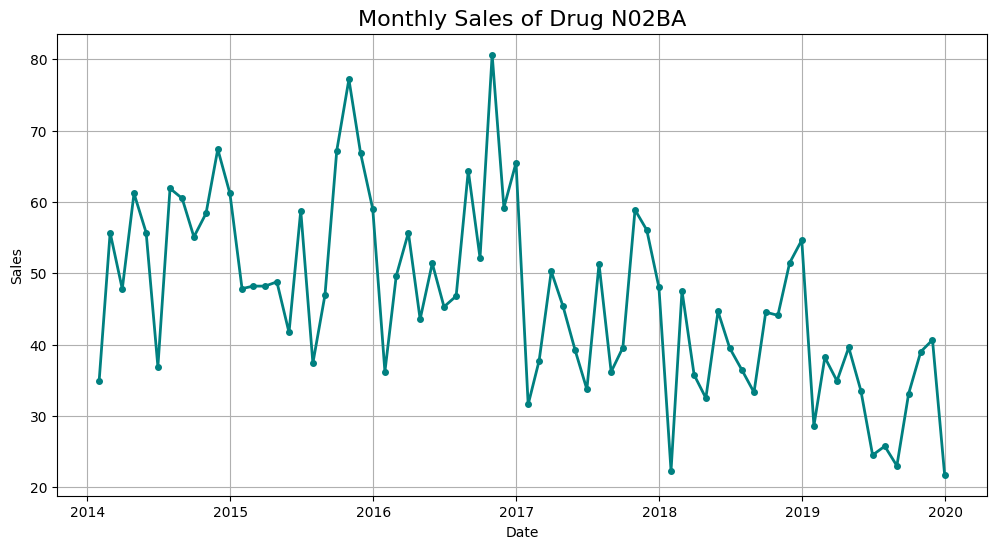

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(sales_monthly, color='teal', linewidth=2, marker='o', markersize=4)
plt.title("Monthly Sales of Drug N02BA", fontsize=16)
plt.xlabel("Date")
plt.ylabel("Sales")
plt.grid(True)
plt.show()


### Seasonal Decompose

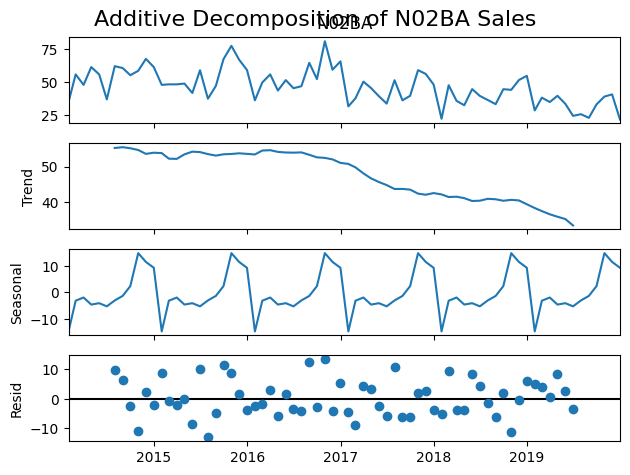

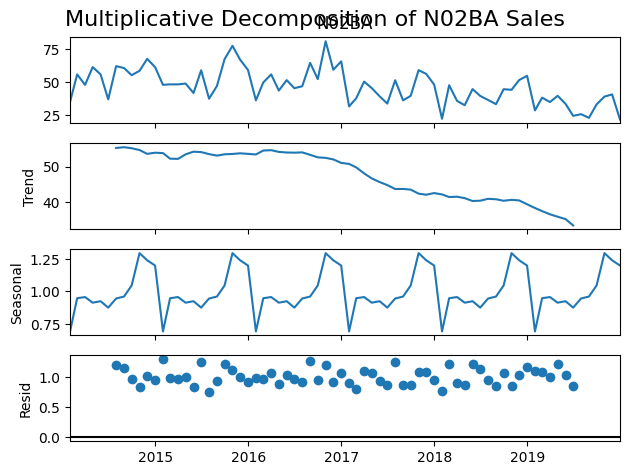

In [ ]:
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

sales_monthly = sales_monthly.dropna()

additive_result = seasonal_decompose(sales_monthly, model='additive', period=12)

multiplicative_result = seasonal_decompose(sales_monthly, model='multiplicative', period=12)

additive_result.plot()
plt.suptitle("Additive Decomposition of N02BA Sales", fontsize=16)
plt.show()

multiplicative_result.plot()
plt.suptitle("Multiplicative Decomposition of N02BA Sales", fontsize=16)
plt.show()

### Moving Averages (50-day and 200-day)

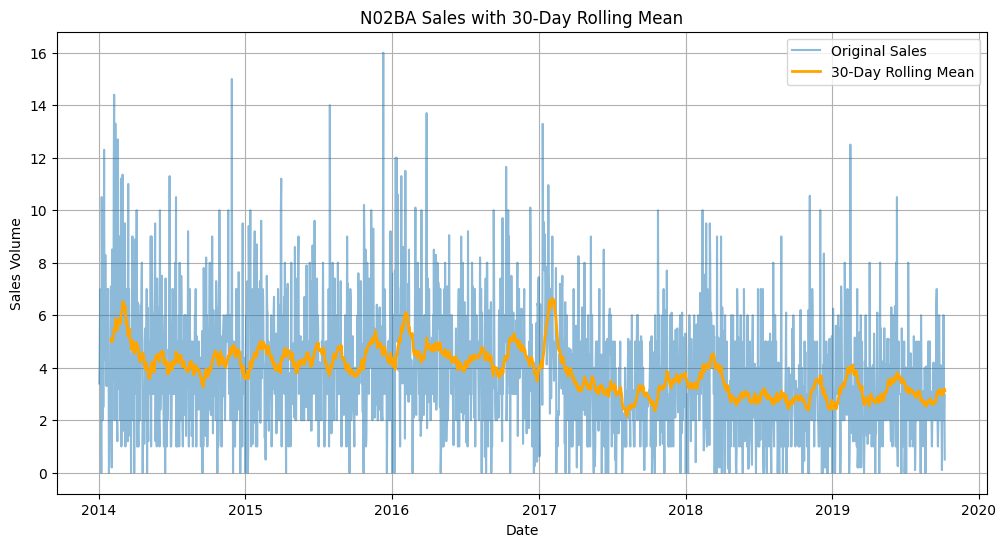

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

sales_df = pd.read_csv('salesdaily.csv')

sales_df['datum'] = pd.to_datetime(sales_df['datum'], format='mixed', errors='coerce')

sales_df = sales_df[['datum', 'N02BA']].dropna()
sales_df.rename(columns={'datum': 'date', 'N02BA': 'value'}, inplace=True)

sales_df['rolling_mean'] = sales_df['value'].rolling(window=30).mean()

plt.figure(figsize=(12, 6))
plt.plot(sales_df['date'], sales_df['value'], label='Original Sales', alpha=0.5)
plt.plot(sales_df['date'], sales_df['rolling_mean'], label='30-Day Rolling Mean', color='orange', linewidth=2)
plt.xlabel('Date')
plt.ylabel('Sales Volume')
plt.title('N02BA Sales with 30-Day Rolling Mean')
plt.legend()
plt.grid()
plt.show()

### Check Stationarity (ADF & KPSS Test)

In [ ]:
from statsmodels.tsa.stattools import adfuller, kpss

def adf_test(series):
    result = adfuller(series.dropna())
    print("ADF Statistic:", result[0])
    print("p-value:", result[1])
    print("Critical Values:", result[4])
    print("Stationary" if result[1] < 0.05 else "Not Stationary")

def kpss_test(series):
    result = kpss(series.dropna(), regression='c', nlags="auto")
    print("KPSS Statistic:", result[0])
    print("p-value:", result[1])
    print("Critical Values:", result[3])
    print("Stationary" if result[1] > 0.05 else "Not Stationary")

print(" ADF Test:")
adf_test(sales_df['N02BA'])
print("\n KPSS Test:")
kpss_test(sales_df['N02BA'])

 ADF Test:
ADF Statistic: -6.135329852530983
p-value: 8.213354081009834e-08
Critical Values: {'1%': -3.433485707610957, '5%': -2.8629252188514385, '10%': -2.5675074259130812}
Stationary

 KPSS Test:
KPSS Statistic: 5.222088749369964
p-value: 0.01
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
Not Stationary


### Differencing to Make Series Stationary

In [ ]:
sales_df = sales_df.reset_index(drop=True)
sales_df['N02BA_diff1'] = sales_df['N02BA'].diff().dropna()


In [ ]:
sales_df['N02BA_diff1'] = sales_df['N02BA'].diff().dropna()

print(" ADF Test on Differenced Data:")
adf_test(sales_df['N02BA_diff1'])

print("\n KPSS Test on Differenced Data:")
kpss_test(sales_df['N02BA_diff1'])


 ADF Test on Differenced Data:
ADF Statistic: -17.521606448387793
p-value: 4.282567454296215e-30
Critical Values: {'1%': -3.4334902249934984, '5%': -2.862927213384133, '10%': -2.5675084878859504}
Stationary

 KPSS Test on Differenced Data:
KPSS Statistic: 0.06944873447125291
p-value: 0.1
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
Stationary


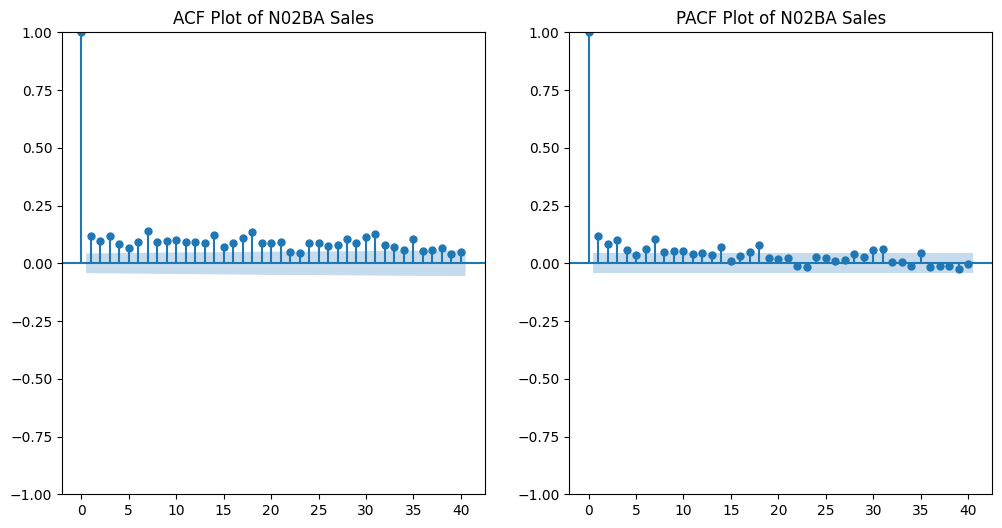

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))

plt.subplot(121)
plot_acf(sales_df['N02BA'].dropna(), lags=40, ax=plt.gca())
plt.title("ACF Plot of N02BA Sales")

plt.subplot(122)
plot_pacf(sales_df['N02BA'].dropna(), lags=40, ax=plt.gca())
plt.title("PACF Plot of N02BA Sales")

plt.show()

### ARIMA Model

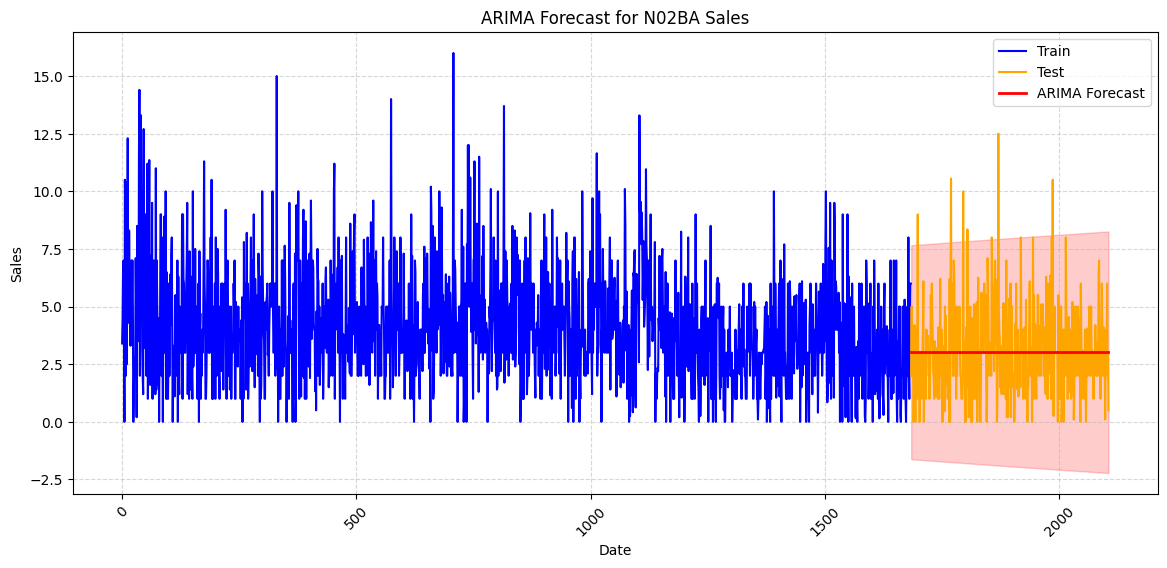

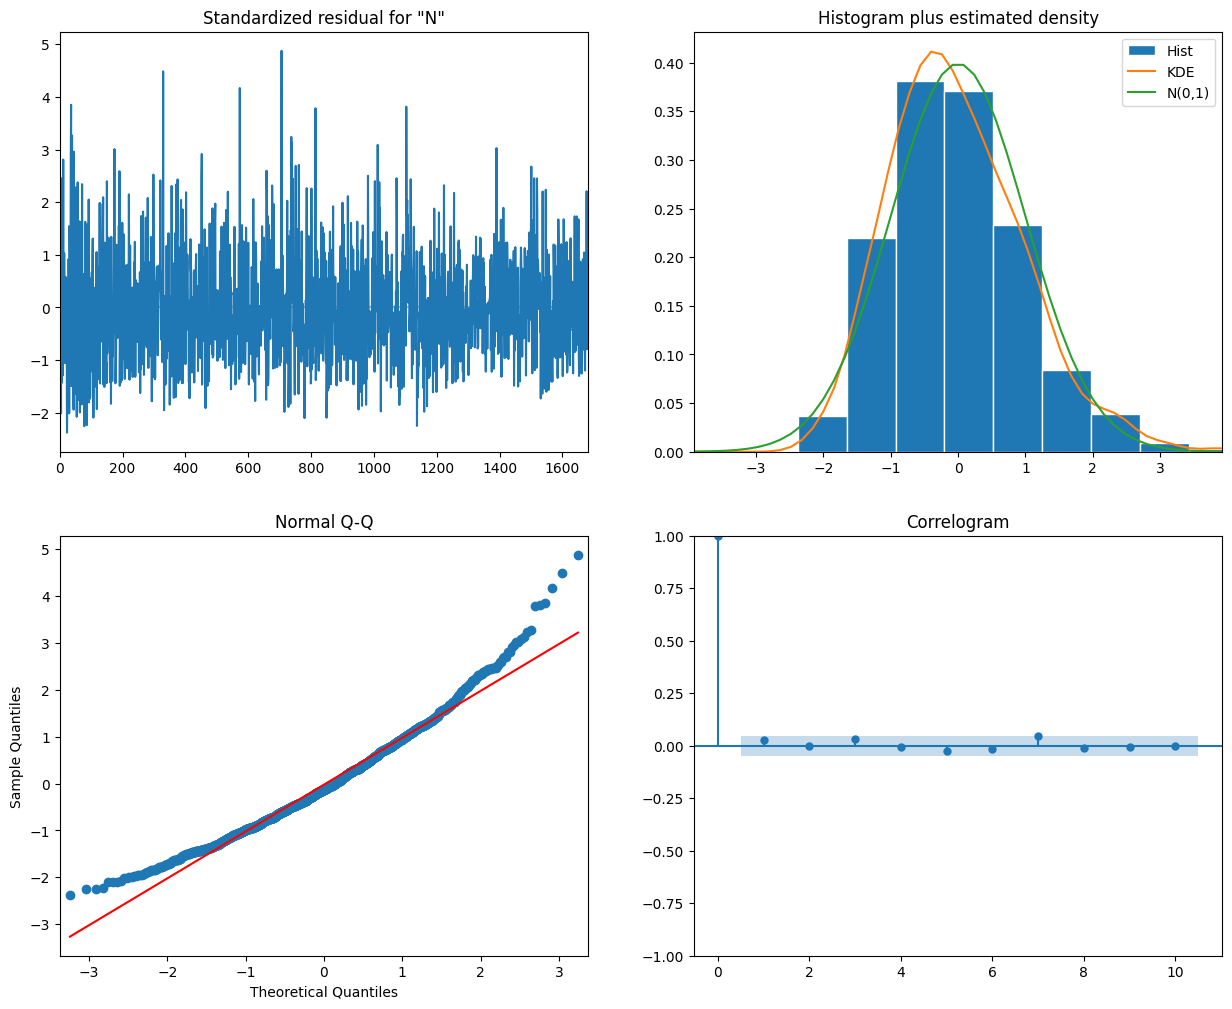

In [ ]:
import pmdarima as pm
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

train_size = int(len(sales_df) * 0.8)
train, test = sales_df[:train_size], sales_df[train_size:]

model_auto_arima = pm.auto_arima(train['N02BA'], seasonal=False, stepwise=True, suppress_warnings=True)

arima_model = ARIMA(train['N02BA'], order=model_auto_arima.order)
arima_fit = arima_model.fit()

arima_forecast = arima_fit.get_forecast(steps=len(test))
forecast_mean = arima_forecast.predicted_mean
conf_int = arima_forecast.conf_int()

plt.figure(figsize=(14, 6))
plt.plot(train['N02BA'], label="Train", color="blue")
plt.plot(test['N02BA'], label="Test", color='orange')
plt.plot(test.index, forecast_mean, label="ARIMA Forecast", color='red', linewidth=2)
plt.fill_between(test.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='red', alpha=0.2)

plt.title("ARIMA Forecast for N02BA Sales")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.xticks(rotation=45)
plt.show()
arima_fit.plot_diagnostics(figsize=(15, 12))
plt.show()

### SARIMA Model

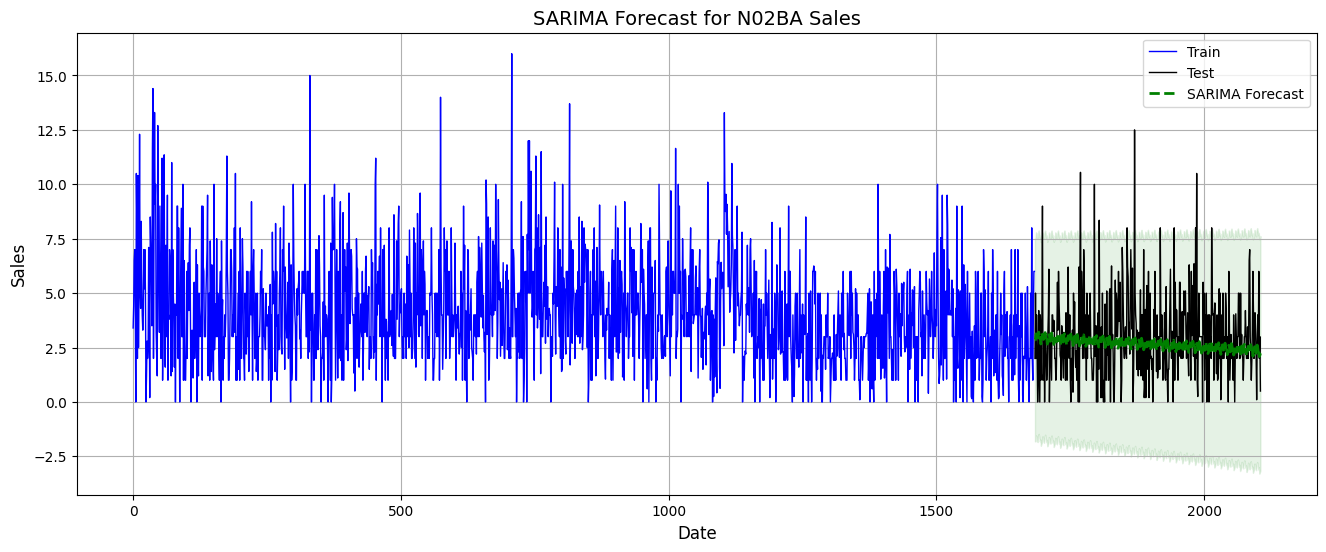

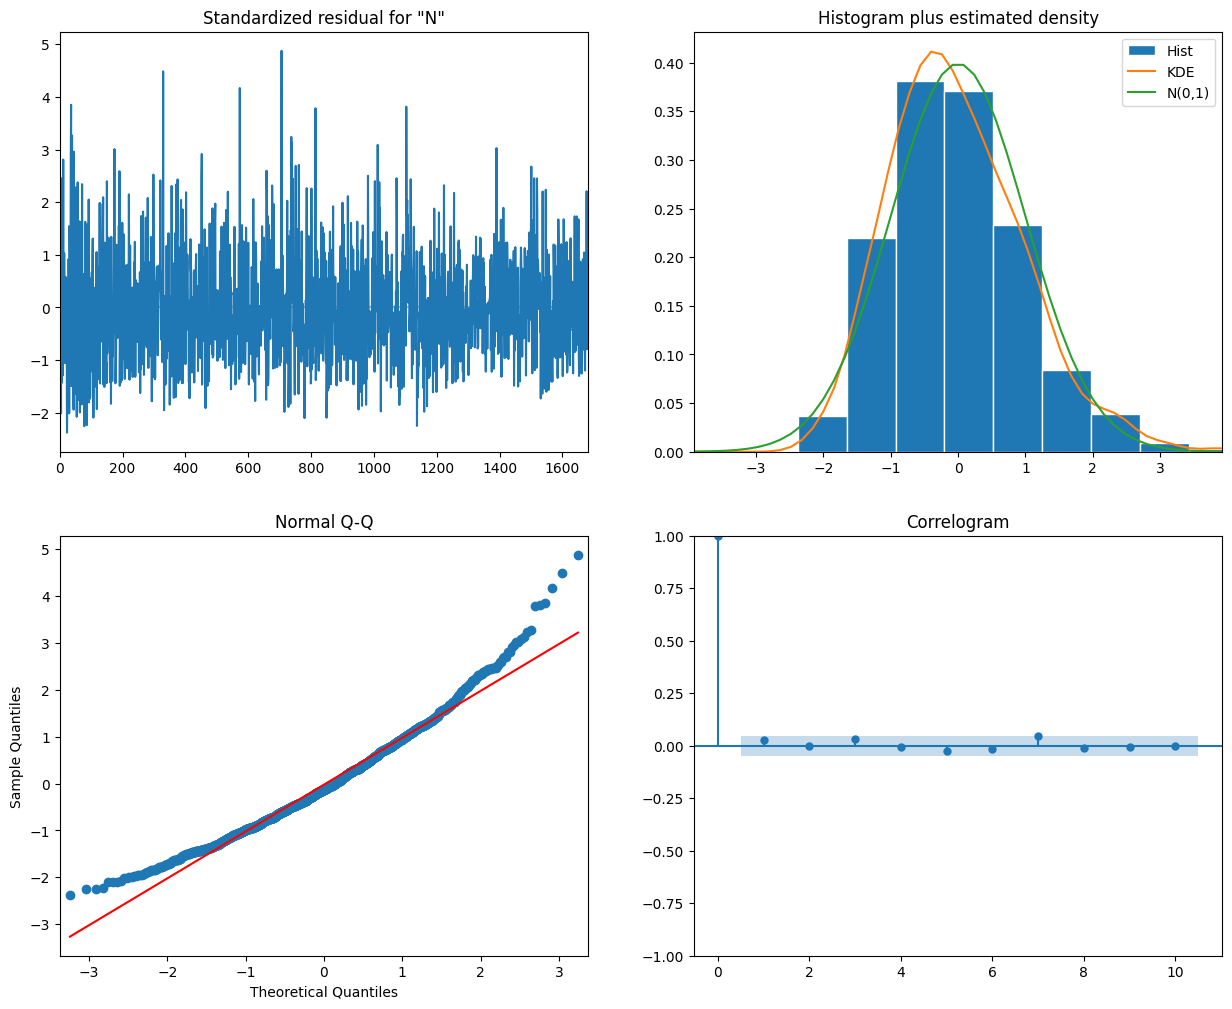

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt

sarima_model = SARIMAX(train['N02BA'], order=(1,1,1), seasonal_order=(1,1,1,12))
sarima_fit = sarima_model.fit()

sarima_forecast = sarima_fit.forecast(steps=len(test))

conf_int = sarima_fit.get_forecast(steps=len(test)).conf_int()

plt.figure(figsize=(16,6))
plt.plot(train['N02BA'], label="Train", color='blue', linewidth=1)
plt.plot(test['N02BA'], label="Test", color='black', linewidth=1)
plt.plot(test.index, sarima_forecast, label="SARIMA Forecast", color='green', linestyle='dashed', linewidth=2)

plt.fill_between(test.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='green', alpha=0.1)

plt.title("SARIMA Forecast for N02BA Sales", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Sales", fontsize=12)
plt.legend()
plt.grid(True)

plt.show()
arima_fit.plot_diagnostics(figsize=(15, 12))
plt.show()


### Exponential Smoothing

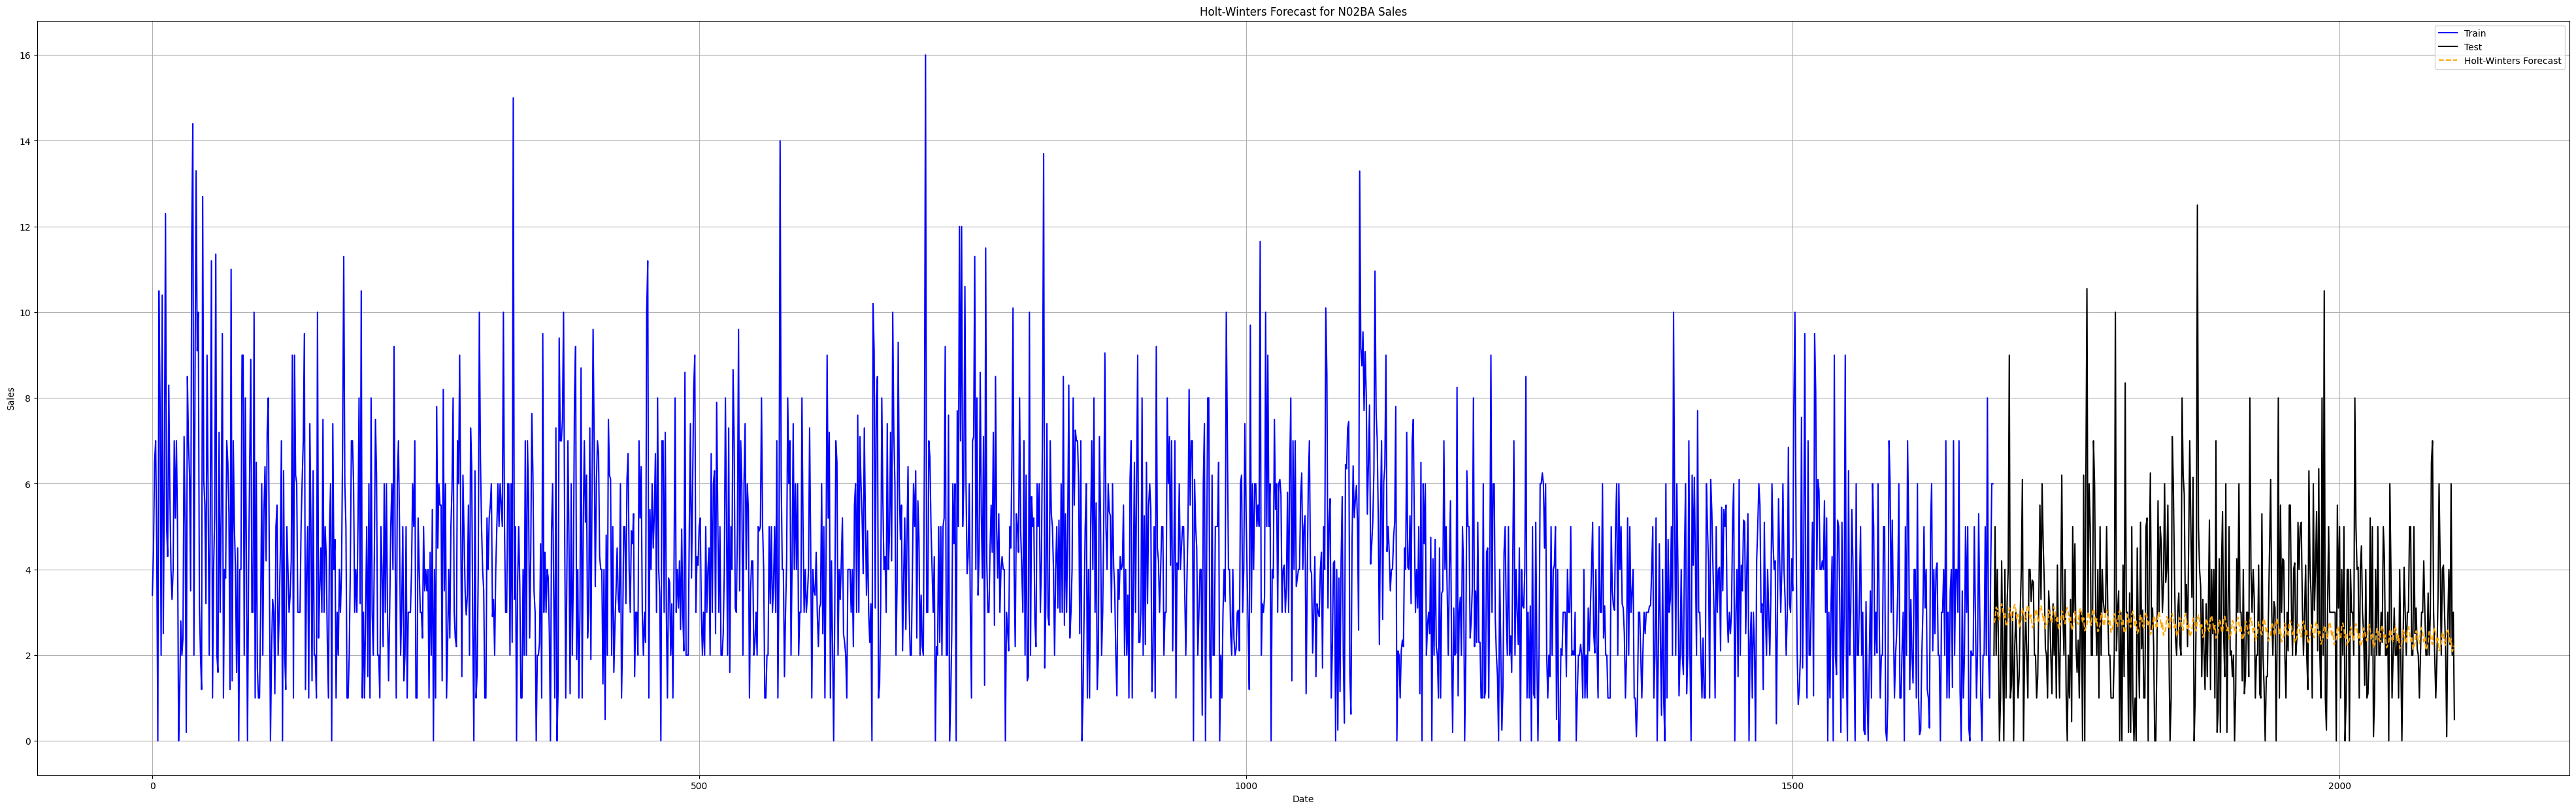

In [ ]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import matplotlib.pyplot as plt

hw_model = ExponentialSmoothing(train['N02BA'], trend='add', seasonal='add', seasonal_periods=12)
hw_fit = hw_model.fit()

hw_forecast = hw_fit.forecast(steps=len(test))

plt.figure(figsize=(50,15))
plt.plot(train['N02BA'], label="Train", color='blue')
plt.plot(test['N02BA'], label="Test", color='black')
plt.plot(test.index, hw_forecast, label="Holt-Winters Forecast", color='orange', linestyle='dashed')

plt.title("Holt-Winters Forecast for N02BA Sales")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.grid()
plt.show()

### GARCH

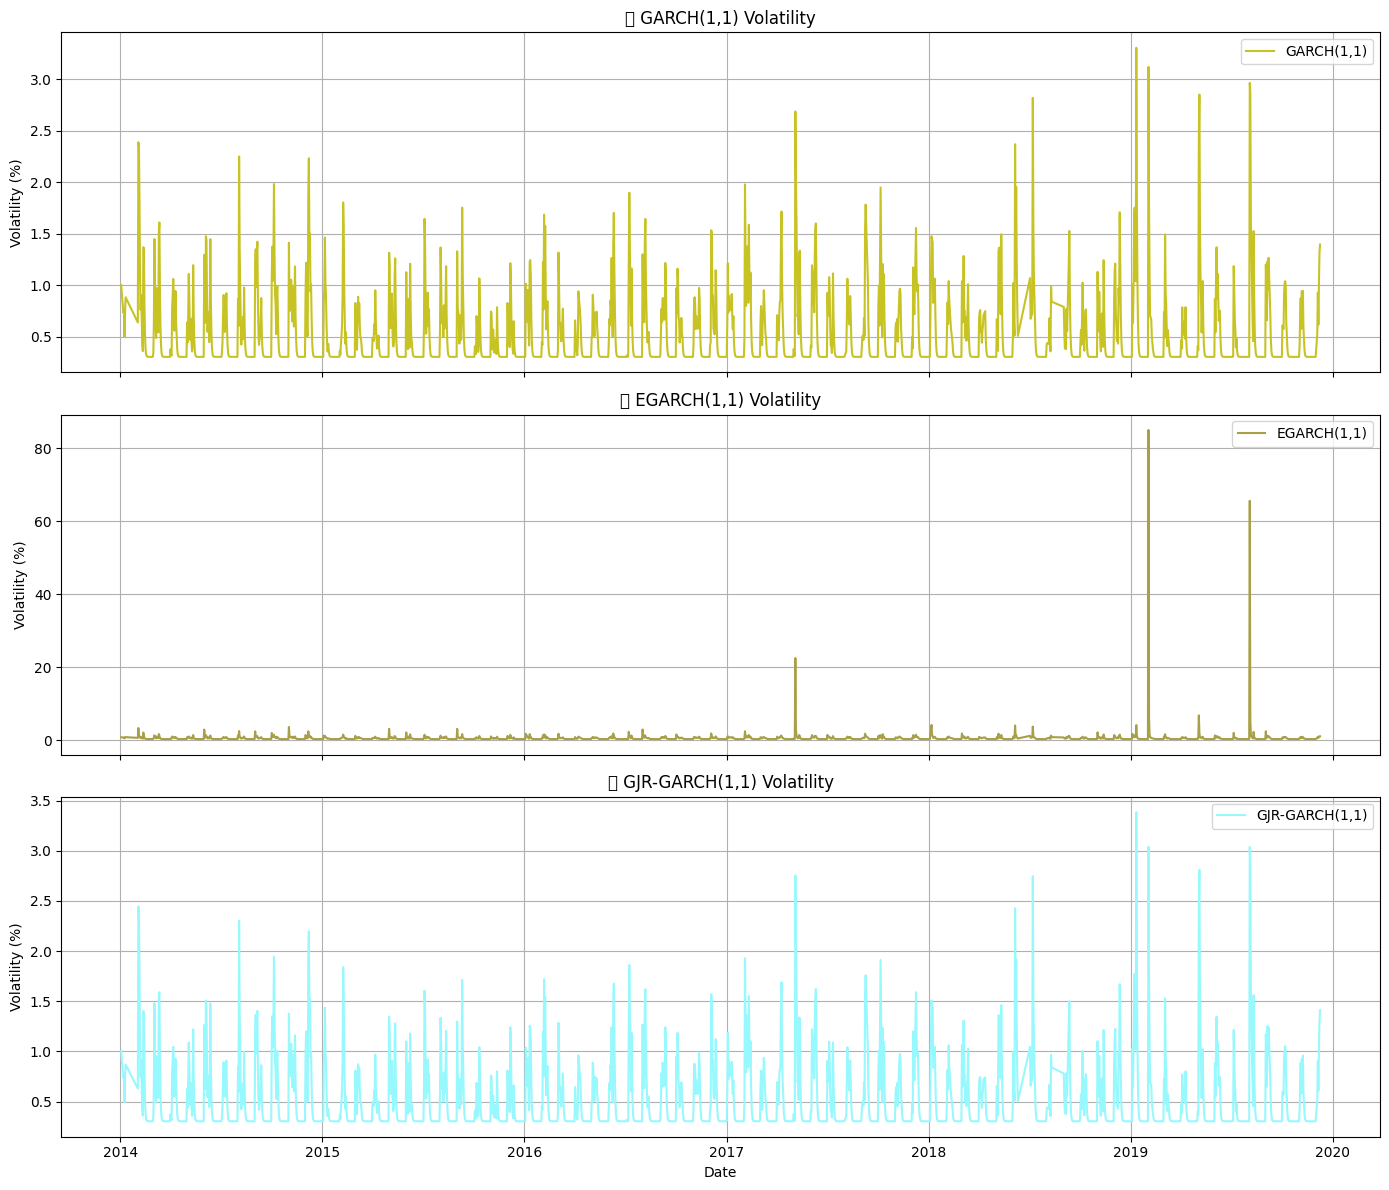

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from arch import arch_model

df = pd.read_csv('salesdaily.csv')
df['datum'] = pd.to_datetime(df['datum'], dayfirst=True, errors='coerce')
df = df[['datum', 'N02BA']].dropna()
df.rename(columns={'datum': 'Date', 'N02BA': 'Sales'}, inplace=True)
df.set_index('Date', inplace=True)
df = df.asfreq('D').fillna(method='ffill')

df['Returns'] = np.log(df['Sales'] / df['Sales'].shift(1))

df['Returns'].replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(subset=['Returns'], inplace=True)

models = {
    "GARCH(1,1)": arch_model(df['Returns'], vol='Garch', p=1, q=1, mean='Constant'),
    "EGARCH(1,1)": arch_model(df['Returns'], vol='EGarch', p=1, q=1, mean='Constant'),
    "GJR-GARCH(1,1)": arch_model(df['Returns'], vol='Garch', p=1, o=1, q=1, mean='Constant')
}

volatility = {}
for name, model in models.items():
    fitted = model.fit(disp='off')
    volatility[name] = fitted.conditional_volatility

fig, axes = plt.subplots(3, 1, figsize=(14, 12), sharex=True)

for ax, (name, vol) in zip(axes, volatility.items()):
    ax.plot(df.index, vol, label=name, color=np.random.rand(3,))
    ax.set_title(f"📈 {name} Volatility")
    ax.set_ylabel("Volatility (%)")
    ax.legend()
    ax.grid()

plt.xlabel("Date")
plt.tight_layout()
plt.show()

### PROPHET

ADF Test Statistic: -15.136419764427137
p-value: 7.111402579427189e-28
Critical Value (1%): -3.4383303387882793
Critical Value (5%): -2.8650625183820577
Critical Value (10%): -2.5686456901154977


13:49:04 - cmdstanpy - INFO - Chain [1] start processing
13:49:04 - cmdstanpy - INFO - Chain [1] done processing


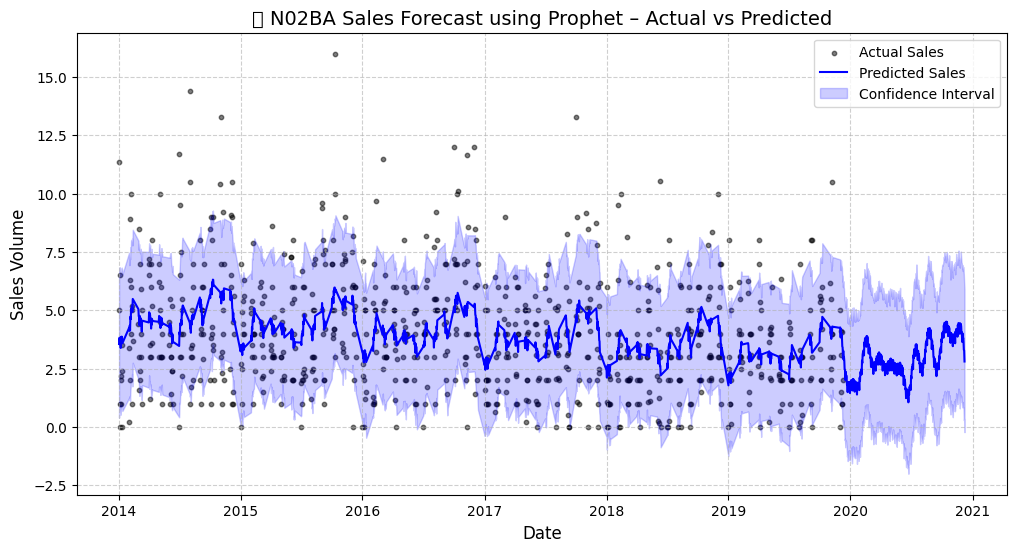

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from statsmodels.tsa.stattools import adfuller

df = pd.read_csv('salesdaily.csv')
df['datum'] = pd.to_datetime(df['datum'], dayfirst=True, errors='coerce')
df = df[['datum', 'N02BA']].dropna()
df.rename(columns={'datum': 'ds', 'N02BA': 'y'}, inplace=True)

df = df.reset_index(drop=True)
df['y_diff1'] = df['y'].diff()
df_diff = df.dropna()

adf_result = adfuller(df_diff['y_diff1'])
print("ADF Test Statistic:", adf_result[0])
print("p-value:", adf_result[1])
for key, value in adf_result[4].items():
    print(f"Critical Value ({key}): {value}")

model = Prophet()
model.fit(df[['ds', 'y']])

future = model.make_future_dataframe(periods=365)
forecast = model.predict(future)

plt.figure(figsize=(12, 6))

plt.scatter(df['ds'], df['y'], color='black', label="Actual Sales", alpha=0.5, s=10)

plt.plot(forecast['ds'], forecast['yhat'], color='blue', label="Predicted Sales")

plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'],
                 color='blue', alpha=0.2, label="Confidence Interval")

plt.title("📈 N02BA Sales Forecast using Prophet – Actual vs Predicted", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Sales Volume", fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error
import numpy as np

merged = df.merge(forecast[['ds', 'yhat']], on='ds')

y_true = merged['y']
y_pred = merged['yhat']

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
print(f"RMSE (Root Mean Squared Error): {rmse:.2f}")

RMSE (Root Mean Squared Error): 2.33


In [ ]:
from sklearn.metrics import mean_squared_error
import numpy as np

actual = df['y']
predicted = forecast.loc[:len(actual)-1, 'yhat']

rmse = np.sqrt(mean_squared_error(actual, predicted))

print(f"Prophet Model RMSE: {rmse:.4f}")

Prophet Model RMSE: 2.5136
